# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wfdb
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks
from sklearn.metrics import classification_report
from matplotlib.cm import ScalarMappable
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, LSTMCell, Dense, Dropout
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tensorflow.keras.models import load_model

# Load and Preprocess Data

In [2]:
mitbih_record_ids = [
    '100', '101', '102', '103',
    '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119',
    '121', '122', '123', '124', '200', '201', '202', '203', '205',
    '207', '208', '209', '210', '212', '213', '214', '215', '217',
    '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

all_segments = []
all_labels = []

for rec_id in mitbih_record_ids:
    try:
        record = wfdb.rdrecord(str(rec_id), pn_dir='mitdb')
        annotation = wfdb.rdann(str(rec_id), 'atr', pn_dir='mitdb')

        ecg_signal = record.p_signal[:, 0]  # MLII
        beat_indices = annotation.sample
        beat_symbols = annotation.symbol

        for i, idx in enumerate(beat_indices):
            symbol = beat_symbols[i]

            if symbol == '+' or symbol == '~':
                continue

            if idx - 90 < 0 or idx + 90 > len(ecg_signal):
                continue

            segment = ecg_signal[idx - 90 : idx + 90]
            label = 0 if symbol == 'N' else 1

            all_segments.append(segment)
            all_labels.append(label)

    except Exception as e:
        print(f"Failed to process record {rec_id}: {e}")


In [3]:
X = np.array(all_segments)
y = np.array(all_labels)

print(f"Total ECG segments: {len(X)}")
print(f"Class distribution: {np.unique(y, return_counts=True)}")


Total ECG segments: 110714
Class distribution: (array([0, 1]), array([75033, 35681]))


In [4]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"LSTM Input Shape: {X.shape}")


LSTM Input Shape: (110714, 180, 1)


In [5]:
X_normal = X[y == 0]
y_normal = y[y == 0]

X_abnormal = X[y == 1]
y_abnormal = y[y == 1]

# Downsample normal class to match abnormal
X_normal_down, y_normal_down = resample(
    X_normal, y_normal,
    replace=False,
    n_samples=len(y_abnormal),
    random_state=42
)

# Combine and shuffle
X_balanced = np.concatenate((X_normal_down, X_abnormal))
y_balanced = np.concatenate((y_normal_down, y_abnormal))

X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

print(f"Balanced shape: {X_balanced.shape}, Labels: {np.unique(y_balanced, return_counts=True)}")


Balanced shape: (71362, 180, 1), Labels: (array([0, 1]), array([35681, 35681]))


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (57089, 180, 1), (57089,)
Test shape: (14273, 180, 1), (14273,)


In [7]:
# Normalize each segment: (value - mean) / std
X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / (X_train.std(axis=1, keepdims=True) + 1e-6)
X_test = (X_test - X_test.mean(axis=1, keepdims=True)) / (X_test.std(axis=1, keepdims=True) + 1e-6)


In [9]:
model = Sequential([
    Input(shape=(180, 1)),
    RNN(LSTMCell(256), return_sequences=True),
    Dropout(0.4),
    RNN(LSTMCell(256)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 62s 112ms/step - accuracy: 0.7087 - loss: 0.5337 - val_accuracy: 0.9037 - val_loss: 0.2609
Epoch 2/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 68s 98ms/step - accuracy: 0.9150 - loss: 0.2449 - val_accuracy: 0.9292 - val_loss: 0.2017
Epoch 3/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.9265 - loss: 0.2172 - val_accuracy: 0.9386 - val_loss: 0.1850
Epoch 4/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.9345 - loss: 0.1979 - val_accuracy: 0.9416 - val_loss: 0.1821
Epoch 5/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.9402 - loss: 0.1846 - val_accuracy: 0.9421 - val_loss: 0.1737
Epoch 6/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.9414 - loss: 0.1825 - val_accuracy: 0.9397 - val_loss: 0.1771
Epoch 7/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.9449 - loss: 0.1708 - val_accuracy: 0.9512 - val_loss: 0.1495
Epoch 8/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - accuracy: 0.9466 - loss: 0.1642 

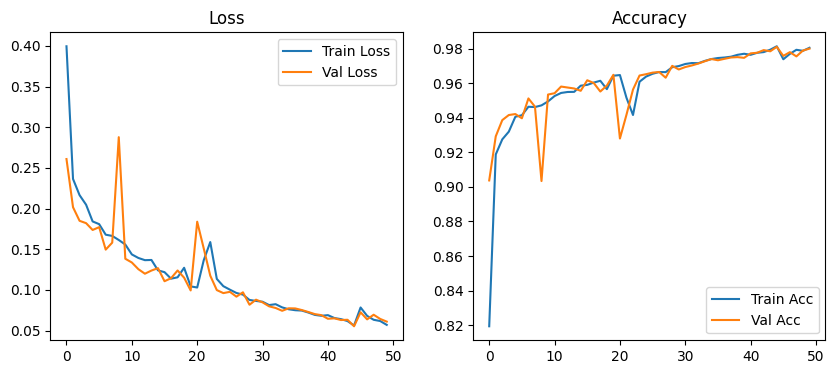

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      7137
    Abnormal       0.99      0.98      0.98      7136

    accuracy                           0.98     14273
   macro avg       0.98      0.98      0.98     14273
weighted avg       0.98      0.98      0.98     14273



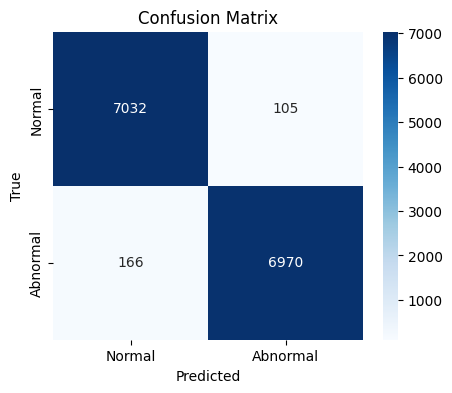

In [11]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [30]:
model.save("./LSTM on ECG Anomaly Detector.keras")

In [28]:
!pip install tf-keras-vis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.9 MB/s eta 0:00:00


In [23]:
# Load the model
model = load_model('/your_path') #LSTM on ECG Anomaly Detector.keras

(1, 1)
(180,)


In [ ]:
if isinstance(model, tf.keras.Sequential):
    input_layer = Input(shape=(180, 1))
    output_layer = model(input_layer)
    functional_model = Model(inputs=input_layer, outputs=output_layer)
else:
    functional_model = model

def score_function_binary(output):
    # Assuming the model outputs the probability of the positive class (shape (None, 1))
    # We want the saliency for the positive class prediction
    return output[:, 0]

replace2linear = ReplaceToLinear()
saliency = Saliency(functional_model, model_modifier=replace2linear, clone=True)

# Get indices for 250 normal and 250 abnormal samples from X_test
normal_indices_test = np.where(y_test == 0)[0][:250]
abnormal_indices_test = np.where(y_test == 1)[0][:250]

# Combine the indices
sample_indices_to_explain = np.concatenate((normal_indices_test, abnormal_indices_test))

samples_to_explain = X_test[sample_indices_to_explain]

saliency_map = saliency(score_function_binary, samples_to_explain)


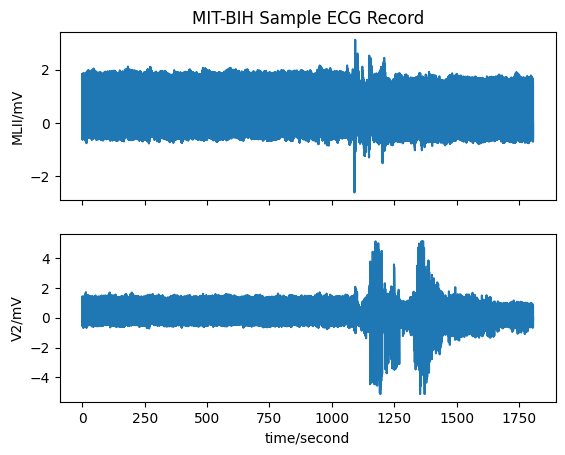

In [ ]:
record = wfdb.rdrecord('103', pn_dir='mitdb')  # Record 100 from MIT-BIH

wfdb.plot_wfdb(record=record, title='MIT-BIH Sample ECG Record')

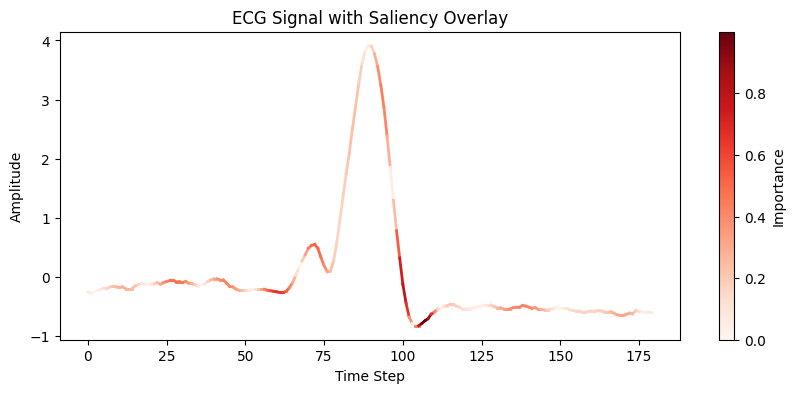

In [14]:

# Select one test sample and its saliency
sample_idx = 0
ecg_signal = X_test[sample_idx].squeeze()  # shape (180,)
saliency_values = saliency_map[sample_idx].squeeze()  # shape (180,)

# Normalize saliency
normalized_saliency = (saliency_values - np.min(saliency_values)) / (np.max(saliency_values) - np.min(saliency_values) + 1e-6)

# Plot
plt.figure(figsize=(10, 4))
ax = plt.gca()

# Create a ScalarMappable object to represent the color mapping
cmap = plt.cm.Reds
sm = ScalarMappable(cmap=cmap)
sm.set_array(normalized_saliency)

for i in range(len(ecg_signal)-1):
    plt.plot([i, i+1], [ecg_signal[i], ecg_signal[i+1]],
             color=cmap(normalized_saliency[i]), linewidth=2)

plt.colorbar(sm, ax=ax, label='Importance')
plt.title("ECG Signal with Saliency Overlay")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()

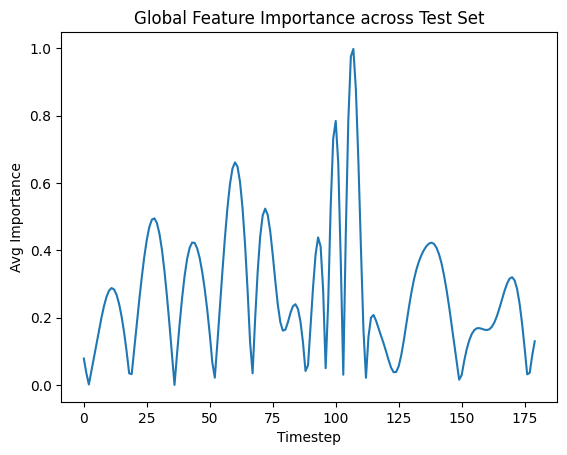

In [15]:
global_saliency = np.mean(saliency_map, axis=0)

plt.plot(global_saliency)
plt.title("Global Feature Importance across Test Set")
plt.xlabel("Timestep")
plt.ylabel("Avg Importance")
plt.show()


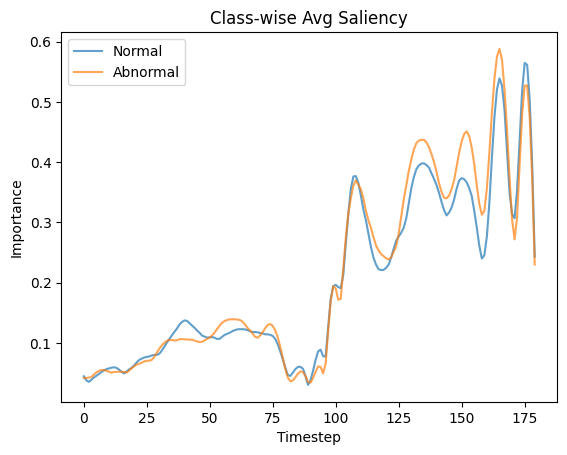

In [22]:
y_test_subset  = y_test[sample_indices_to_explain]

normal_idx = np.where(y_test == 0)[0][:100]
abnormal_idx = np.where(y_test == 1)[0][:100]

avg_saliency_normal = np.mean(saliency_map[normal_idx], axis=0)
avg_saliency_abnormal = np.mean(saliency_map[abnormal_idx], axis=0)

plt.plot(avg_saliency_normal, label="Normal", alpha=0.7)
plt.plot(avg_saliency_abnormal, label="Abnormal", alpha=0.7)
plt.title("Class-wise Avg Saliency")
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Importance")
plt.show()


447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
Misclassified Samples: 271


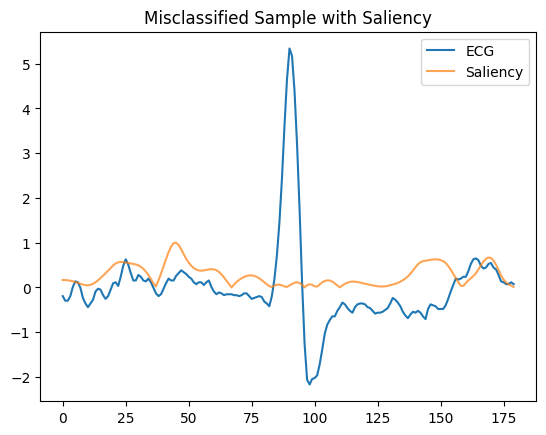

In [20]:
# Get predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Find misclassified sample indices
misclassified_idx = np.where(y_pred != y_test)[0]
print("Misclassified Samples:", len(misclassified_idx))

# Visualize saliency for 1 misclassified example
idx = misclassified_idx[0]
plt.plot(X_test[idx].squeeze(), label='ECG')
plt.plot(saliency_map[idx].squeeze(), label='Saliency', alpha=0.7)
plt.legend()
plt.title("Misclassified Sample with Saliency")
plt.show()


In [23]:
sample_idx = 0  # You can change this index
sample_ecg = X_test[sample_idx]
sample_label = y_test[sample_idx]
sample_saliency = saliency_map[sample_idx]

# Find peaks in the saliency map
peaks, _ = find_peaks(sample_saliency, height=0.5)

print("Important time steps:", peaks)


Important time steps: [107 118 132 163]


In [25]:

def explain_sample(ecg_idx, y_true, y_pred, saliency_map, record_id=None):
    peaks, _ = find_peaks(saliency_map, height=0.5)
    peak_str = ", ".join(str(p) for p in peaks[:3])

    condition = "Abnormal" if y_pred == 1 else "Normal"
    explanation = (
        f"Classified as {condition} due to influential signal patterns "
        f"around time steps: {peak_str}."
    )

    return {
        "Sample Index": ecg_idx,
        "Record ID": record_id if record_id else "N/A",
        "True Label": "Abnormal" if y_true == 1 else "Normal",
        "Predicted": condition,
        "Salient Time Steps": peak_str,
        "Explanation": explanation
    }


In [27]:
results = []

for i in range(len(samples_to_explain)):
    result = explain_sample(
        ecg_idx=i,
        y_true=y_test_subset[i],
        y_pred=(model.predict(samples_to_explain[i:i+1]) > 0.5).astype("int32")[0][0],
        saliency_map=saliency_map[i].squeeze(),
        record_id="record_{}".format(i)  # if available
    )
    results.append(result)

df_explanations = pd.DataFrame(results)
df_explanations.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

,Sample Index,Record ID,True Label,Predicted,Salient Time Steps,Explanation
0,0,record_0,Normal,Normal,"107, 118, 132",Classified as Normal due to influential signal...
1,1,record_1,Normal,Normal,"104, 111, 121",Classified as Normal due to influential signal...
2,2,record_2,Normal,Normal,"106, 166, 176",Classified as Normal due to influential signal...
3,3,record_3,Normal,Normal,"125, 148, 163",Classified as Normal due to influential signal...
4,4,record_4,Normal,Normal,"112, 139, 153",Classified as Normal due to influential signal...


In [31]:
df_explanations["Correct"] = df_explanations["True Label"] == df_explanations["Predicted"]
summary_counts = df_explanations["Correct"].value_counts()
print(summary_counts)


Correct
True     493
False      7
Name: count, dtype: int64


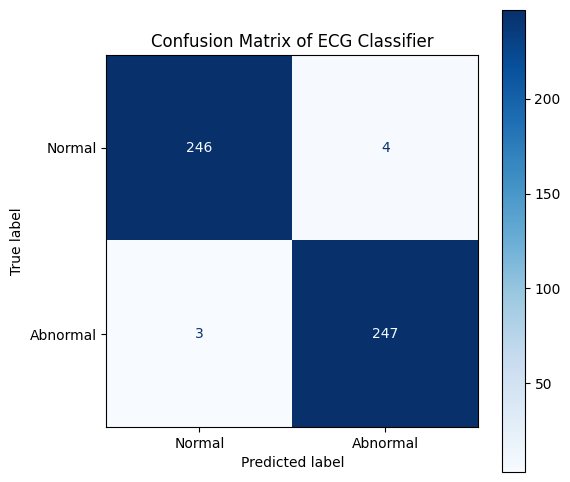

In [32]:

# Convert labels to 0/1
y_true = df_explanations["True Label"].map({"Normal": 0, "Abnormal": 1})
y_pred = df_explanations["Predicted"].map({"Normal": 0, "Abnormal": 1})

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix of ECG Classifier")
plt.show()


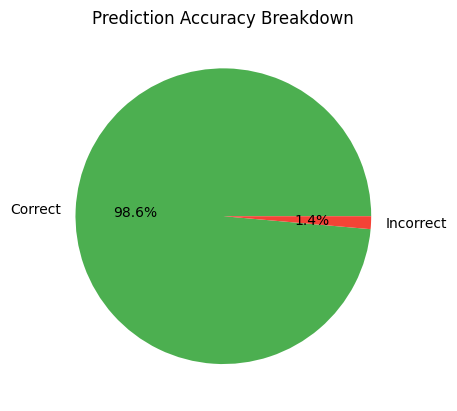

In [33]:
df_explanations["Correct"].value_counts().plot(
    kind='pie',
    labels=["Correct", "Incorrect"],
    autopct='%1.1f%%',
    colors=["#4CAF50", "#F44336"],
    title="Prediction Accuracy Breakdown"
)
plt.ylabel("")
plt.show()


In [10]:
!pip freeze > requirements.txt